# Experiments with Preprocessing 

### Based on 

https://github.com/fepegar/torchio/blob/master/examples/README.md 

In [112]:
import os
import sys
import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
import nibabel as nib
from nilearn.plotting import *
from nilearn import image
import torchio as tio
import seaborn as sns

In [39]:
import imp

import data_processor
imp.reload(data_processor)
import utils.visualization_tools as visualization_tools
imp.reload(visualization_tools)
from utils.visualization_tools import *

## Original data

In [40]:
fcd_pirogov_seg_data = data_processor.DataMriSegmentation(sample='pirogov', prefix='fcd', mask='seg', ignore_missing=True,
                         coord_min=(30,30,30, ), img_shape=(192, 192, 192, ),
                         image_path= '../../datasets/fcd_classification_bank',
                         targets_path= 'targets/targets_fcd_bank.csv')

print('\n')
print(f'Dataset size: {len(fcd_pirogov_seg_data)}')
print(f'Labels distribution: {np.unique(fcd_pirogov_seg_data.target, return_counts=True)}\n')

#Example of data 
img, seg = fcd_pirogov_seg_data[1]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))

  7%|▋         | 1/15 [00:00<00:01,  8.10it/s]

Assembling data for: pirogov sample.


100%|██████████| 15/15 [00:01<00:00,  9.51it/s]




Dataset size: 15
Labels distribution: (array([1]), array([15]))

Image shape: torch.Size([1, 192, 192, 192])
Segmentation shape: torch.Size([1, 192, 192, 192])


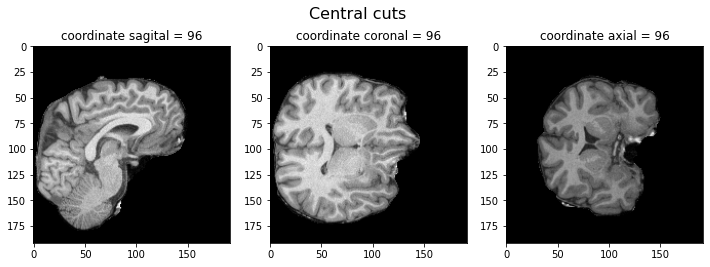

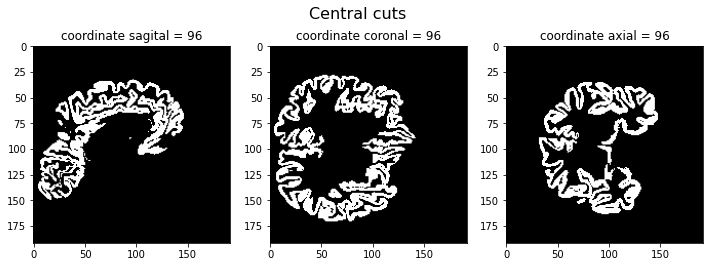

In [41]:
plot_central_cuts(img)
plot_central_cuts(seg)

## Torchio data

In [49]:
subjects = []

for (image_path, label_path) in zip(fcd_pirogov_seg_data.img_files, fcd_pirogov_seg_data.img_seg ):
    subject_dict = {
        'MRI' : torchio.Image(image_path, torchio.INTENSITY),
        'LABEL': torchio.Image(label_path, torchio.LABEL),
    }
    subject = torchio.Subject(subject_dict)
    subjects.append(subject)

## 1. CropOrPad

https://torchio.readthedocs.io/transforms/preprocessing.html#croporpad

### Before 

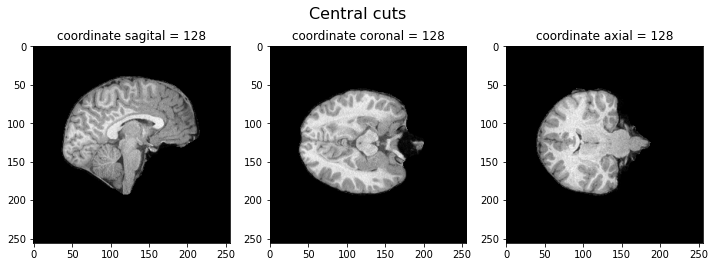

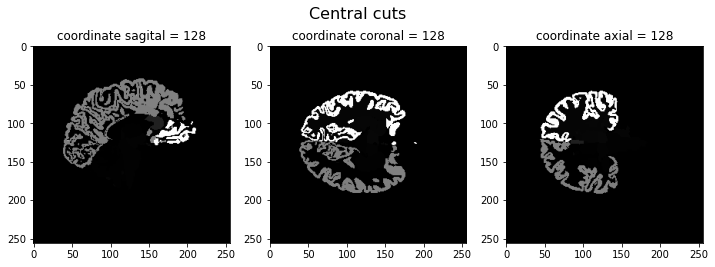

In [84]:
img = subjects[0].MRI.data.numpy()
seg = subjects[0].LABEL.data.numpy()

plot_central_cuts(img[0])
plot_central_cuts(seg[0])

### After 

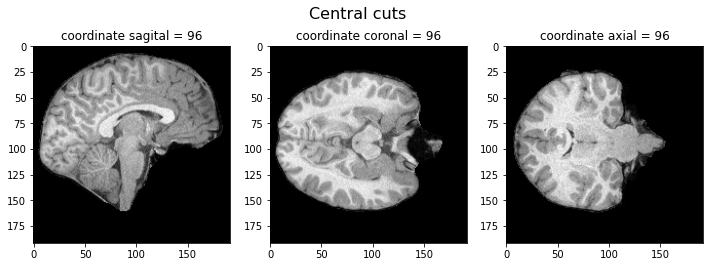

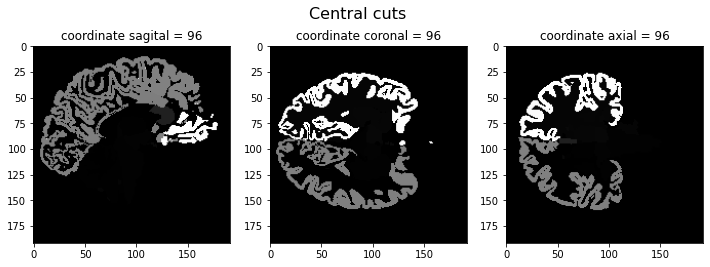

In [88]:
CropOrPad = tio.CropOrPad((192, 192, 192))
CropOrPad_subjects = []

for subject in subjects[:1]:    
    CropOrPad_subjects.append(CropOrPad(subject))  

plot_central_cuts(CropOrPad_subjects[0].MRI.data.numpy()[0])
plot_central_cuts(CropOrPad_subjects[0].LABEL.data.numpy()[0])

## 2. RandomAffine

https://torchio.readthedocs.io/transforms/augmentation.html#randomaffine

### Before 

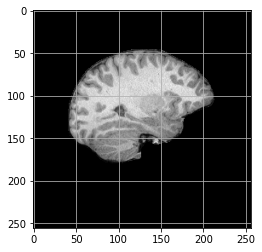

In [92]:
img = subjects[0].MRI.data.numpy()

plt.imshow(img[0, 100, :,:], cmap = 'gray')
plt.grid(True)
plt.show()

### After 

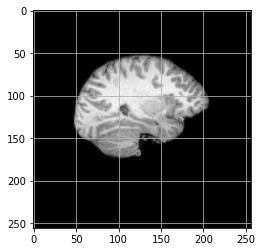

In [95]:
RandomAffine = tio.RandomAffine()
RandomAffine_subjects = []

for subject in subjects[:1]:    
    RandomAffine_subjects.append(RandomAffine(subject))  

img = RandomAffine_subjects[0].MRI.data.numpy()

plt.imshow(img[0, 100, :,:], cmap = 'gray')
plt.grid(True)
plt.show()

## 3. RandomFlip

https://torchio.readthedocs.io/transforms/augmentation.html#torchio.transforms.RandomFlip

### Before 

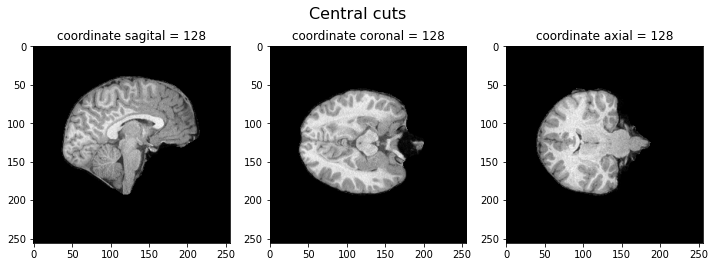

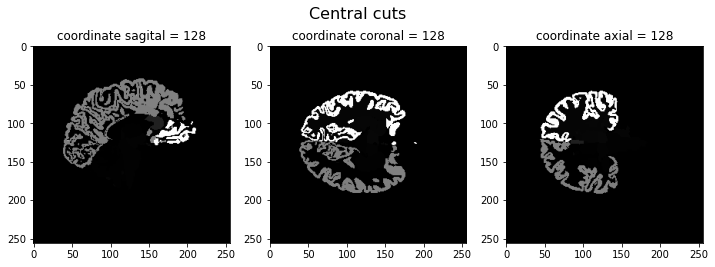

In [96]:
img = subjects[0].MRI.data.numpy()
seg = subjects[0].LABEL.data.numpy()

plot_central_cuts(img[0])
plot_central_cuts(seg[0])

### After 

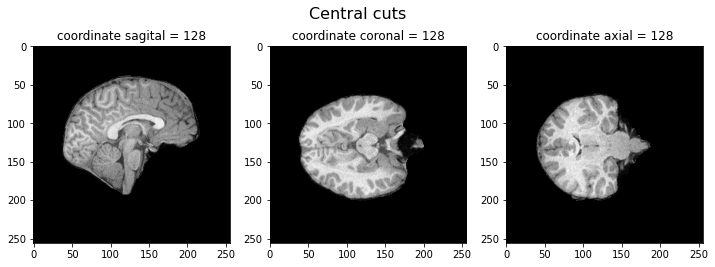

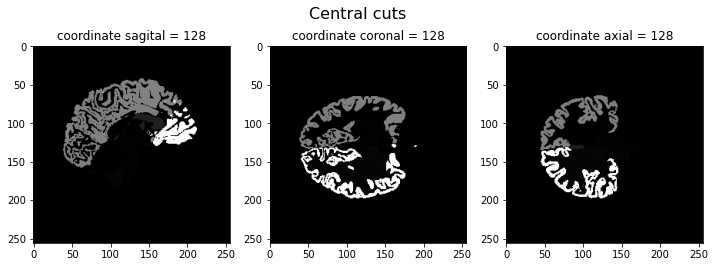

In [103]:
RandomFlip = tio.RandomFlip(axes=(0,))
RandomFlip_subjects = []

for subject in subjects[:1]:    
    RandomFlip_subjects.append(RandomFlip(subject))  

plot_central_cuts(RandomFlip_subjects[0].MRI.data.numpy()[0])
plot_central_cuts(RandomFlip_subjects[0].LABEL.data.numpy()[0])

## 4. RandomElasticDeformation

https://torchio.readthedocs.io/transforms/augmentation.html#torchio.transforms.RandomElasticDeformation

### Before 

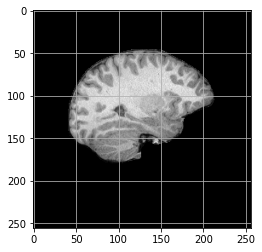

In [105]:
img = subjects[0].MRI.data.numpy()

plt.imshow(img[0, 100, :,:], cmap = 'gray')
plt.grid(True)
plt.show()

### After 

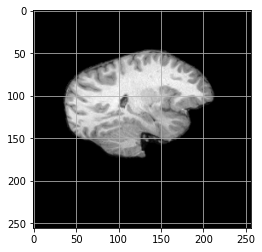

In [110]:
max_displacement = 20, 20, 20  # in x, y and z directions
RandomElasticDeformation = tio.RandomElasticDeformation(max_displacement=max_displacement, num_control_points=10)
RandomElasticDeformation_subjects = []

for subject in subjects[:1]:    
    RandomElasticDeformation_subjects.append(RandomElasticDeformation(subject))  

img = RandomElasticDeformation_subjects[0].MRI.data.numpy()

plt.imshow(img[0, 100, :,:], cmap = 'gray')
plt.grid(True)
plt.show()

## 5. ZNormalization 
https://torchio.readthedocs.io/transforms/preprocessing.html#znormalization

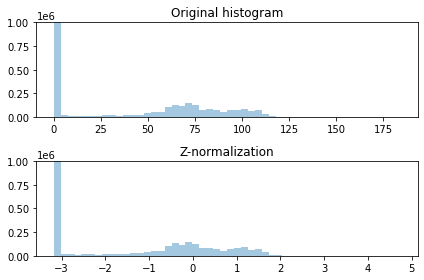

In [124]:
img = subjects[0].MRI.data.numpy()

standardize = tio.ZNormalization(masking_method = tio.ZNormalization.mean) # equal to lambda x: x > x.mean()
standardized = standardize(subjects[0])

fig, axes = plt.subplots(2, 1)
sns.distplot(img, ax = axes[0], kde=False)
sns.distplot(standardized.MRI.data, ax = axes[1], kde=False)
axes[0].set_title('Original histogram')
axes[1].set_title('Z-normalization')
axes[0].set_ylim((0, 1e6))
axes[1].set_ylim((0, 1e6))
plt.tight_layout()

## 6. Histogram standardization

https://torchio.readthedocs.io/transforms/preprocessing.html#torchio.transforms.HistogramStandardization

In [127]:
histogram_landmarks_path = 'landmarks/fcd_train_data_landmarks.npy'

# image_paths = list(fcd_pirogov_seg_data.img_files.values)
 
# landmarks = tio.HistogramStandardization.train(
#     image_paths,
#     output_path=histogram_landmarks_path,
# )

landmarks = np.load(histogram_landmarks_path)

100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


In [129]:
landmarks

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   4.83824872,
       100.        ])

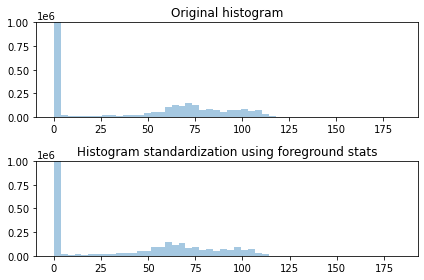

In [139]:
img = subjects[0].MRI.data.numpy()

standardize = tio.HistogramStandardization(landmarks={'MRI': landmarks}) # equal to lambda x: x > x.mean()
standardized = standardize(subjects[0])

fig, axes = plt.subplots(2, 1)
sns.distplot(img, ax = axes[0], kde=False)
sns.distplot(standardized.MRI.data, ax = axes[1], kde=False)
axes[0].set_title('Original histogram')
axes[1].set_title('Histogram standardization using foreground stats')
axes[0].set_ylim((0, 1e6))
axes[1].set_ylim((0, 1e6))

plt.tight_layout()

### Before 

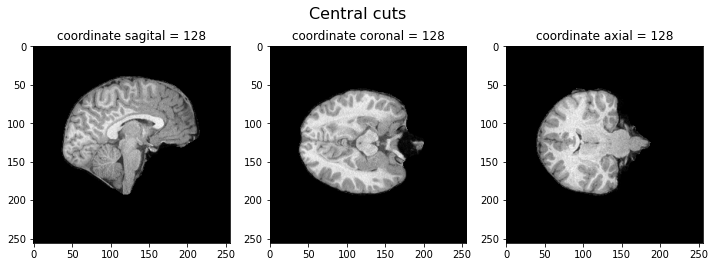

In [141]:
plot_central_cuts(img[0])

### After 

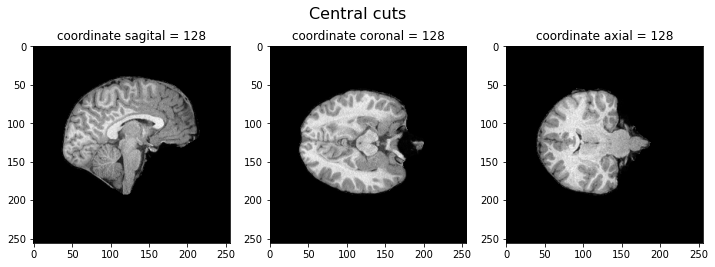

In [142]:
plot_central_cuts(standardized.MRI.data.numpy()[0])

## 7. RandomBiasField

https://torchio.readthedocs.io/transforms/augmentation.html#torchio.transforms.RandomBiasField

In [143]:
img = subjects[0].MRI.data.numpy()

RandomBiasField = tio.RandomBiasField(coefficients=1)
img_RandomBiasField = RandomBiasField(subjects[0])

### Before 

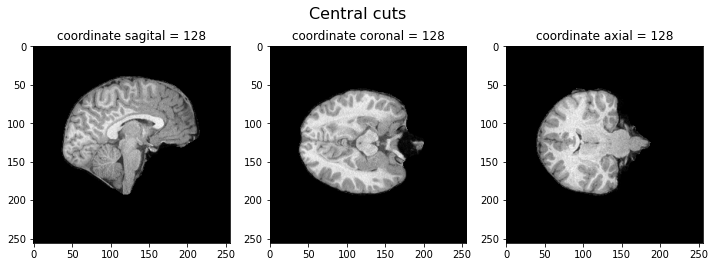

In [144]:
plot_central_cuts(img[0])

### After 

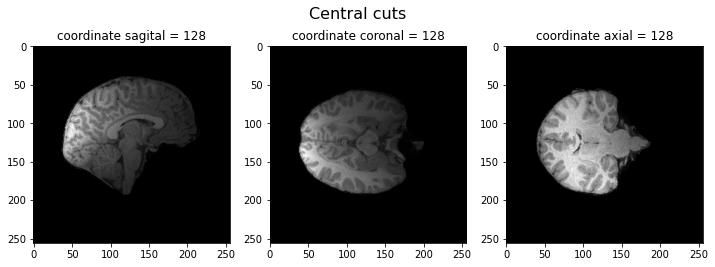

In [146]:
plot_central_cuts(img_RandomBiasField.MRI.data.numpy()[0])